# Pre-training

## Import Library

In [3]:
pip install jieba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 55.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314477 sha256=9a880474c35d4c7461d6e84db0d2ca6813a63c836fdce577b4b06e9281c69b7d
  Stored in directory: /root/.cache/pip/wheels/7d/74/cf/08c94db4b784e2c1ef675a600b7b5b281fd25240dcb954ee7e
Successfully built jieba

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install chardet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 24.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import math
import time
import logging
logging.basicConfig(level=logging.INFO)
import numpy as np
# import matplotlib as plt  # 绘图
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

import chardet            # 检测字符编码
import re
import jieba              # 分词
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

## File Path

In [6]:
DataPath = "/work/data/"
NamePath = os.path.join(DataPath, 'inf.txt')
StopWordPath = "/work/cn_stopwords.txt"
FontPath = "/work/simsun.ttc"
prop = FontProperties(fname=FontPath)
SavePath = "/work/Pic/"

## Encode Verification

In [7]:
# 找到data中所有文件的通用编码方式
def try_open_file(file_path, encoding):
    try:
        with open(file_path, "r", encoding=encoding) as file:
            file.read()  
        return True
    except UnicodeDecodeError:
        return False

def find_common_encoding(folder_path, possible_encodings):
    for encoding in possible_encodings:
        all_files_openable = True
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            if os.path.isfile(file_path):
                if not try_open_file(file_path, encoding):
                    all_files_openable = False
                    break
        if all_files_openable:
            return encoding
    return None

folder_path = DataPath
possible_encodings = ['utf-8', 'gb18030', 'gbk', 'big5', 'cp1252', 'latin1']
common_encoding = find_common_encoding(folder_path, possible_encodings)
if common_encoding:
    print(f"Common encoding for all files in {folder_path}: {common_encoding}")
else:
    print("No common encoding found for all files.")


Common encoding for all files in /work/data/: gb18030


采用 gb18030 进行编码

# Experimental Studies

## Part1 Zip's Law

In [ ]:
class Zipf_Law:
    def __init__(self, DataPath, FontPath, SavePath):
        self.data_path = DataPath
        self.font_path = FontPath      # 中文字体文件路径
        self.save_path = SavePath
        # 获取 DataPath 目录下除了 "inf.txt" 以外的所有 txt 文件的文件路径
        self.fileList = [os.path.join(self.data_path, filename) for filename in os.listdir(self.data_path) if filename.endswith('.txt') and filename != 'inf.txt']
    
    def wordCount(self, txtFilePath):
        if not os.path.exists(txtFilePath):
            raise Exception('File not exists')
        
        # 词频统计字典
        wordCntMap = {}
        
        with open(txtFilePath, 'r', encoding='gb18030') as txtFile:
            rawTxt = txtFile.read()
            # 去掉无意义词汇和标点符号
            rawTxt = re.sub(r'[-—－——〖〗【】「」《》『』（）()：:，、；。！？【】“”‘’\'\'""‘’]{1,}', '', rawTxt)
            wordList = jieba.lcut(rawTxt)  # 精确模式分词
            for word in wordList:
                if re.match('^[\u4e00-\u9fff]+$', word):  # 使用正则表达式匹配中文字符
                    wordCntMap[word] = wordCntMap.get(word, 0) + 1
        
        # 将词频统计字典按值降序排序
        sorted_wordCnt = sorted(wordCntMap.items(), key=lambda x: x[1], reverse=True)
        
        return sorted_wordCnt

    def wordCountAll(self):

        # 统计所有文件的词频
        total_wordCnt = {}
        
        for filePath in self.fileList:
            sorted_wordCnt = self.wordCount(filePath)
            
            # 合并词频统计结果
            for word, count in sorted_wordCnt:
                total_wordCnt[word] = total_wordCnt.get(word, 0) + count
                
        # 将词频统计字典按值降序排序
        sorted_total_wordCnt = sorted(total_wordCnt.items(), key=lambda x: x[1], reverse=True)
        
        return sorted_total_wordCnt

    def plotWordFrequency(self, word_freq_data, title):
        # 提取排名和词频
        ranks_total = np.arange(1, len(word_freq_data) + 1)
        frequencies_total = [pair[1] for pair in word_freq_data]

        # 绘制Zipf Law（对数坐标）
        plt.loglog(ranks_total, frequencies_total, label='Total')

        
        plt.title(title)
        plt.xlabel('Rank (log scale)')
        plt.ylabel('Frequency (log scale)')
        plt.legend(loc='upper right', ncol=2)
        plt.savefig(os.path.join(self.save_path, 'Total_Zipf.png'), bbox_inches='tight', dpi=300)

        # 显示图表
        plt.show()
    
    def plotWordFrequencyForEachFile(self, title):
       
        for filePath in self.fileList:
            sorted_wordCnt = self.wordCount(filePath)
            # 提取排名和词频
            ranks = np.arange(1, len(sorted_wordCnt) + 1)
            frequencies = [pair[1] for pair in sorted_wordCnt]
            # 绘制排名-词频统计图
            plt.loglog(ranks, frequencies, label=os.path.basename(filePath))

        # 设置中文字体
        prop = FontProperties(fname=self.font_path)
        plt.title(title)
        plt.xlabel('Rank (log scale)')
        plt.ylabel('Frequency (log scale)')
        plt.legend(loc='upper right', ncol=2, prop=prop)
        plt.savefig(os.path.join(self.save_path, 'Single_Zipf.png'), bbox_inches='tight', dpi=300)
        plt.show()


Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.311 seconds.
Prefix dict has been built successfully.


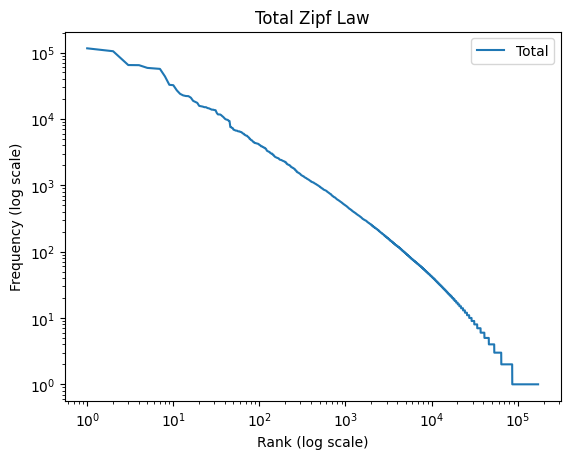

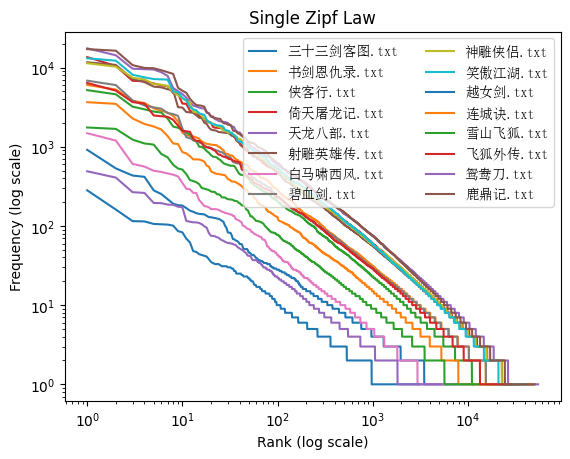

In [ ]:
draw_zipf = Zipf_Law(DataPath, FontPath, SavePath)

# 统计所有文本文件的词频
total_wordCnt = draw_zipf.wordCountAll()

# 绘制Zipf Law 图
draw_zipf.plotWordFrequency(total_wordCnt, 'Total Zipf Law')
draw_zipf.plotWordFrequencyForEachFile('Single Zipf Law')

## Part2 N-gram

### Get training corpus

In [ ]:
class TrainCorpus:
    def __init__(self, DataPath, FontPath, SavePath):
        self.data_path = DataPath
        self.font_path = FontPath      # 中文字体文件路径
        self.save_path = SavePath
        # 获取 DataPath 目录下除了 "inf.txt" 以外的所有 txt 文件的文件路径
        self.fileList = [os.path.join(self.data_path, filename) for filename in os.listdir(self.data_path) if filename.endswith('.txt') and filename != 'inf.txt']
    
    def Train(self):
        return self.getCorpus(self.data_path)
    
    def getCorpus(self, rootDir):
        corpus = []
        r1 = u'[a-zA-Z0-9’!"#$%&\'()*+,-./:：;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'  
        listdir = os.listdir(rootDir)
        count=0

        stopwords = []  
        with open('/work/cn_stopwords.txt', 'r', encoding='utf-8') as f:  # 停词表
            
            stopwords = [line.strip() for line in f.readlines()]
            stopwords.append(' ')

        for file in listdir:
            path  = os.path.join(rootDir, file)
            if os.path.isfile(path):
                with open(os.path.abspath(path), "r", encoding='gb18030') as file:
                    filecontext = file.read();
                    filecontext = re.sub(r1, '', filecontext) 
                    stopwords2 = [' ','\n','本书来自www.cr173.com免费txt小说下载站','更多更新免费电子书请关注www.cr173.com','\u3000','目录']
                    for word in stopwords2:
                        filecontext = filecontext.replace(word, '')
                    for _ in stopwords:
                        filecontext = filecontext.replace(word, '')    
                    
                    count += len(filecontext)
                    corpus.append(filecontext)
            elif os.path.isdir(path):
                TraversalFun.AllFiles(self, path)
        return corpus, count

### Calculate Entropy using N_gram

In [ ]:
class Entropy:
    def __init__(self, corpus, count):
        self.corpus = corpus
        self.count = count
        self.words_tf = {}
        self.bigram_tf = {}
        self.trigram_tf = {}
    # 计算词频
    def get_tf(self, tf_dic, words):
        for i in range(len(words)-1):
            tf_dic[words[i]] = tf_dic.get(words[i], 0) + 1

    def get_bigram_tf(self, tf_dic, words):
        for i in range(len(words)-1):
            tf_dic[(words[i], words[i+1])] = tf_dic.get((words[i], words[i+1]), 0) + 1

    def get_trigram_tf(self, tf_dic, words):
        for i in range(len(words)-2):
            tf_dic[((words[i], words[i+1]), words[i+2])] = tf_dic.get(((words[i], words[i+1]), words[i+2]), 0) + 1

    def cal_unigram(self, corpus,count):
        before = time.time()
        split_words = []
        words_len = 0
        line_count = 0
        words_tf = {}
        top_n = 10

        for line in corpus:
            for x in jieba.cut(line):
                split_words.append(x)
                words_len += 1

            self.get_tf(words_tf, split_words)
            split_words = []
            line_count += 1
        self.words_tf = words_tf

        print("语料库字数:", count)
        print("分词个数:", words_len)
        print("平均词长:", round(count / words_len, 5))
        
        # sorted_words_tf = sorted(words_tf.items(), key=lambda x: x[1], reverse=True)[:top_n]
        # print(f"Top {top_n} words with high frequency:")
        # for word, freq in sorted_words_tf:
        #     print(f"{word}: {freq}")

        entropy = []
        for uni_word in words_tf.items():
            entropy.append(-(uni_word[1] / words_len) * math.log(uni_word[1] / words_len, 2))
        print("基于词的一元模型的中文信息熵为:", round(sum(entropy), 5), "比特/词")
        after = time.time()
        print("运行时间:", round(after - before, 5), "s")

    def cal_bigram(self, corpus, count):
        before = time.time()
        split_words = []
        words_len = 0
        line_count = 0
        words_tf = {}
        bigram_tf = {}
        top_n = 10
        for line in corpus:
            for x in jieba.cut(line):
                split_words.append(x)
                words_len += 1

            self.get_tf(words_tf, split_words)
            self.get_bigram_tf(bigram_tf, split_words)

            split_words = []
            line_count += 1

        self.words_tf = words_tf
        self.bigram_tf = bigram_tf 

        print("语料库字数:", count)
        print("分词个数:", words_len)
        print("平均词长:", round(count / words_len, 5))

        # sorted_words_tf = sorted(words_tf.items(), key=lambda x: x[1], reverse=True)[:top_n]
        # sorted_bigram_tf = sorted(bigram_tf.items(), key=lambda x: x[1], reverse=True)[:top_n]
        # print(f"Top {top_n} words with high frequency:")
        # for word, freq in sorted_words_tf:
        #     print(f"{word}: {freq}")
        # for word, freq in sorted_bigram_tf:
        #     print(f"{word}: {freq}")

        bigram_len = sum([dic[1] for dic in bigram_tf.items()])
        print("二元模型长度:", bigram_len)

        entropy = []
        for bi_word in bigram_tf.items():
            jp_xy = bi_word[1] / bigram_len  # 计算联合概率p(x,y)
            cp_xy = bi_word[1] / words_tf[bi_word[0][0]]  # 计算条件概率p(x|y)
            entropy.append(-jp_xy * math.log(cp_xy, 2))  # 计算二元模型的信息熵
        print("基于词的二元模型的中文信息熵为:", round(sum(entropy), 5), "比特/词")

        after = time.time()
        print("运行时间:", round(after - before, 5), "s")

    def cal_trigram(self,corpus,count):
        before = time.time()
        split_words = []
        words_len = 0
        line_count = 0
        words_tf = {}
        trigram_tf = {}

        for line in corpus:
            for x in jieba.cut(line):
                split_words.append(x)
                words_len += 1

            self.get_bigram_tf(words_tf, split_words)
            self.get_trigram_tf(trigram_tf, split_words)

            split_words = []
            line_count += 1

        self.words_tf = words_tf
        self.trigram_tf = trigram_tf

        print("语料库字数:", count)
        print("分词个数:", words_len)
        print("平均词长:", round(count / words_len, 5))

        trigram_len = sum([dic[1] for dic in trigram_tf.items()])
        print("三元模型长度:", trigram_len)

        entropy = []
        for tri_word in trigram_tf.items():
            jp_xy = tri_word[1] / trigram_len               # 计算联合概率p(x,y)
            cp_xy = tri_word[1] / words_tf[tri_word[0][0]]  # 计算条件概率p(x|y)
            entropy.append(-jp_xy * math.log(cp_xy, 2))     # 计算三元模型的信息熵
        print("基于词的三元模型的中文信息熵为:", round(sum(entropy), 5), "比特/词")

        after = time.time()
        print("运行时间:", round(after - before , 5), "s")


### Result All

In [ ]:
TraC = TrainCorpus(DataPath, FontPath, SavePath)
corpus, count = TraC.getCorpus(DataPath)
entropy = Entropy(corpus, count)
entropy.cal_unigram(corpus, count)
entropy.cal_bigram(corpus, count)
entropy.cal_trigram(corpus, count)

语料库字数: 7296119
分词个数: 4302516
平均词长: 1.69578
基于词的一元模型的中文信息熵为: 12.16791 比特/词
运行时间: 77.31631 s
语料库字数: 7296119
分词个数: 4302516
平均词长: 1.69578
二元模型长度: 4302499
基于词的二元模型的中文信息熵为: 6.94008 比特/词
运行时间: 85.95495 s
语料库字数: 7296119
分词个数: 4302516
平均词长: 1.69578
三元模型长度: 4302482
基于词的三元模型的中文信息熵为: 2.3115 比特/词
运行时间: 85.08368 s


In [15]:
"""
DefineClass：
    1.存储数据
    2.短句
    3.分词
    4.计算N元模型词频
    5.计算N元模型平均信息熵
"""
class ChineseData:
    def __init__(self, txtname='', txt='', sentences=[], words=[], entropyinit = {}):
        self.txtname = txtname
        self.txt = txt
        self.sentences = sentences
        self.words = words
        global punctuation
        self.punctuation = punctuation
        global stopwords
        self.stopwords = stopwords
        self.entropy = entropyinit

    def sepSentences(self):
        line = ''
        sentences = []
        for w in self.txt:
            if w in self.punctuation and line != '\n':
                if line.strip() != '':
                    sentences.append(line.strip())
                    line = ''
            elif w not in self.punctuation:
                line += w
        self.sentences = sentences

    def sepWords(self):
        words = []
        dete_stopwords = 0
        if dete_stopwords:
            for i in range(len(self.sentences)):
                words.extend([x for x in jieba.cut(self.sentences[i]) if x not in self.stopwords])
        else:
            for i in range(len(self.sentences)):
                words.extend([x for x in jieba.cut(self.sentences[i])])
        self.words = words
    
    def getNmodel(self, phrase_model, n):
        if n == 1:
            for i in range(len(self.words)):
                phrase_model[self.words[i]] = phrase_model.get(self.words[i], 0) + 1
        else:
            for i in range(len(self.words) - (n - 1)):
                if n == 2:
                    condition_t = self.words[i]
                else:
                    condition = []
                    for j in range(n-1):
                        condition.append(self.words[i + j])
                    condition_t = tuple(condition)
                phrase_model[(condition_t, self.words[i+n-1])] = phrase_model.get((condition_t, self.words[i+n-1]), 0) + 1
    
    def getN_1model(self, phrase_model, n):
        if n == 1:
            for i in range(len(self.words)):
                phrase_model[self.words[i]] = phrase_model.get(self.words[i], 0) + 1
        else:
            for i in range(len(self.words) - (n - 1)):
                condition = []
                for j in range(n):
                    condition.append(self.words[i + j])
                condition_t = tuple(condition)
                phrase_model[condition_t] = phrase_model.get(condition_t, 0) + 1
                                
    def calcuNmodelEntropy(self, n, entropy_dic):
        if n < 1 or n >= len(self.words):
            print("Wrong N!")
        elif n == 1:
            phrase_model = {}
            self.getNmodel(phrase_model, 1)
            model_lenth = len(self.words)
            entropy_dic[n] = sum([-(phrase[1] / model_lenth) * math.log(phrase[1] / model_lenth, 2) for phrase in phrase_model.items()])
            entropy_dic[n] = round(entropy_dic[n], 4) 
            # self.entropy[n] = sum([-(phrase[1] / model_lenth) * math.log(phrase[1] / model_lenth, 2) for phrase in phrase_model.items()])
            # self.entropy[n] = round(self.entropy[n], 4)  
            # self.entropy.append(sum([-(phrase[1] / model_lenth) * math.log(phrase[1] / model_lenth, 2) for phrase in phrase_model.items()]))         
            # self.entropy = sum([-(phrase[1] / model_lenth) * math.log(phrase[1] / model_lenth, 2) for phrase in phrase_model.items()])
        else:
            phrase_model_n = {}
            phrase_model_n_1 = {}
            self.getNmodel(phrase_model_n, n)
            self.getN_1model(phrase_model_n_1, n - 1)
            phrase_n_len = sum([phrase[1] for phrase in phrase_model_n.items()])
            entropy = []
            for n_phrase in phrase_model_n.items():
                p_xy = n_phrase[1] / phrase_n_len
                p_x_y = n_phrase[1] / phrase_model_n_1[n_phrase[0][0]] 
                entropy.append(-p_xy * math.log(p_x_y, 2))
            entropy_dic[n] = round(sum(entropy), 4)
            # self.entropy[n] = round(sum(entropy), 4)
            # self.entropy.append(round(sum(entropy), 4))
            # self.entropy = round(sum(entropy), 4)
 
    def run(self):
        self.sepSentences()
        self.sepWords()
        entropy_dic = {}
        self.calcuNmodelEntropy(1, entropy_dic)
        self.calcuNmodelEntropy(2, entropy_dic)
        self.calcuNmodelEntropy(3, entropy_dic)
        self.calcuNmodelEntropy(4, entropy_dic)
        self.entropy = entropy_dic
        

"""
InputOutput：
    1.读取文章数据
    2.读取标点
    3.读取停词
    4.输出图表结果
"""

def read_all_files(path):
    data_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file == 'inf.txt':  # 跳过处理 "inf.txt" 文件
                continue
            filename = os.path.join(root, file)
            with open(filename, 'r', encoding='gb18030') as f:
                txt = f.read()
                txt = txt.replace('本书来自www.cr173.com免费txt小说下载站', '')
                txt = txt.replace('更多更新免费电子书请关注www.cr173.com', '')
                d = ChineseData()
                d.txt = txt
                d.txtname = file.split('.')[0]
                data_list.append(d)
            f.close()
    return data_list

def read_punctuation_list():
    punctuation = [' ','本书来自www.cr173.com免费txt小说下载站','更多更新免费电子书请关注www.cr173.com','目录']
    punctuation.extend(['\n', '\u3000', '\u0020', '\u00A0'])
    return punctuation

def read_stopwords_list(path):
    stopwords = [line.strip() for line in open(path, encoding='UTF-8').readlines()]
    return stopwords

def draw_results_sub(data):
    k = len(data)
    num = []
    for i in range(k):
        count = 0
        for j in range(len(data[i].sentences)):
            count += len(data[i].sentences[j])
        num.append(count)
    labels = []
    for i in range(k):
        labels.append(data[i].txtname + '\n'  + str(num[i]))
    entropylist = []
    for i in range(4):
        entropy = []
        for j in range(k):
            entropy.append(data[j].entropy[i + 1])
        entropylist.append(entropy)

    
    prop = FontProperties(fname=FontPath)
    width = 0.3
    ind = np.linspace(0.5, 0.5 + (k-1) , 1 + (k-1))
    fig = plt.figure(1, figsize=(20, 10), dpi=400)
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)

    ax1.bar(ind, entropylist[0], width, color='green')
    ax2.bar(ind, entropylist[1], width, color='blue')
    ax3.bar(ind, entropylist[2], width, color='yellow')
    ax4.bar(ind, entropylist[3], width, color='red')

    ax1.set_xticks(ind)
    ax1.set_xticklabels(labels, size='small', rotation=40, fontproperties=prop)
    ax1.set_ylim(min(entropylist[0]) - 0.1, max(entropylist[0]) + 0.1)
    ax1.set_ylabel('1-gram Average Entropy', fontproperties=prop)
    for a, b in zip(ind, entropylist[0]):
        ax1.text(a, b + 0.01, b, ha='center', va='bottom', fontproperties=prop, fontsize=7)

    ax2.set_xticks(ind)
    ax2.set_xticklabels(labels, size='small', rotation=40, fontproperties=prop)
    ax2.set_ylim(min(entropylist[1]) - 0.1, max(entropylist[1]) + 0.1)
    ax2.set_ylabel('2-gram Average Entropy', fontproperties=prop)
    for a, b in zip(ind, entropylist[1]):
        ax2.text(a, b + 0.01, b, ha='center', va='bottom', fontproperties=prop, fontsize=7)

    ax3.set_xticks(ind)
    ax3.set_xticklabels(labels, size='small', rotation=40, fontproperties=prop)
    ax3.set_ylim(min(entropylist[2]) - 0.1, max(entropylist[2]) + 0.1)
    ax3.set_ylabel('3-gram Average Entropy', fontproperties=prop)
    for a, b in zip(ind, entropylist[2]):
        ax3.text(a, b + 0.01, b, ha='center', va='bottom', fontproperties=prop, fontsize=7)

    ax4.set_xticks(ind)
    ax4.set_xticklabels(labels, size='small', rotation=40, fontproperties=prop)
    ax4.set_ylim(max(min(entropylist[3]) - 0.1, 0), max(entropylist[3]) + 0.1)
    ax4.set_ylabel('4-gram Average Entropy', fontproperties=prop)
    for a, b in zip(ind, entropylist[3]):
        ax4.text(a, b + 0.01, b, ha='center', va='bottom', fontproperties=prop, fontsize=7)

    fig.suptitle('Chinese Average Entropy', fontsize=12)
    plt.savefig('chinese_entropy.png', bbox_inches='tight',dpi = 400)
    plt.close()



In [16]:
if __name__ == "__main__":
    

    global stopwords
    stopwords = read_stopwords_list(StopWordPath)
    global punctuation
    punctuation = read_punctuation_list()
    data_list = read_all_files(DataPath)
    for i in range(len(data_list)):
        logging.info('正在处理《'+data_list[i].txtname+'》...')
        ChineseData.run(data_list[i])
        logging.info('《'+data_list[i].txtname+'》处理完成...')

    np.save('data_list.npy', data_list)
   
    
    draw_results_sub(data_list)

INFO:root:正在处理《\allChinese》...
INFO:root:《\allChinese》处理完成...
INFO:root:正在处理《三十三剑客图》...
INFO:root:《三十三剑客图》处理完成...
INFO:root:正在处理《书剑恩仇录》...
INFO:root:《书剑恩仇录》处理完成...
INFO:root:正在处理《侠客行》...
INFO:root:《侠客行》处理完成...
INFO:root:正在处理《倚天屠龙记》...
INFO:root:《倚天屠龙记》处理完成...
INFO:root:正在处理《天龙八部》...
INFO:root:《天龙八部》处理完成...
INFO:root:正在处理《射雕英雄传》...
INFO:root:《射雕英雄传》处理完成...
INFO:root:正在处理《白马啸西风》...
INFO:root:《白马啸西风》处理完成...
INFO:root:正在处理《碧血剑》...
INFO:root:《碧血剑》处理完成...
INFO:root:正在处理《神雕侠侣》...
INFO:root:《神雕侠侣》处理完成...
INFO:root:正在处理《笑傲江湖》...
INFO:root:《笑傲江湖》处理完成...
INFO:root:正在处理《越女剑》...
INFO:root:《越女剑》处理完成...
INFO:root:正在处理《连城诀》...
INFO:root:《连城诀》处理完成...
INFO:root:正在处理《雪山飞狐》...
INFO:root:《雪山飞狐》处理完成...
INFO:root:正在处理《飞狐外传》...
INFO:root:《飞狐外传》处理完成...
INFO:root:正在处理《鸳鸯刀》...
INFO:root:《鸳鸯刀》处理完成...
INFO:root:正在处理《鹿鼎记》...
INFO:root:《鹿鼎记》处理完成...


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2cb3a74c-06a9-4cf0-b3a4-3a0dc0022150' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>